In [1]:
import networkx as nx
from scipy.spatial import distance_matrix
import random
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import scipy as sp
import math

In [2]:
def create_graph(adata, degree = 4):
        """
        Converts spatial coordinates into graph using networkx library.
        
        param: adata - ST Slice 
        param: degree - number of edges per vertex

        return: 1) G - networkx graph
                2) node_dict - dictionary mapping nodes to spots
        """
        D = distance_matrix(adata.obsm['spatial'], adata.obsm['spatial'])
        # Get column indexes of the degree+1 lowest values per row
        idx = np.argsort(D, 1)[:, 0:degree+1]
        # Remove first column since it results in self loops
        idx = idx[:, 1:]

        G = nx.Graph()
        for r in range(len(idx)):
            for c in idx[r]:
                G.add_edge(r, c)

        node_dict = dict(zip(range(adata.shape[0]), adata.obs.index))
        return G, node_dict
    
def generate_graph_from_labels(adata, labels_dict,knn):
    """
    Creates and returns the graph and dictionary {node: cluster_label} for specified layer
    """
    
    g, node_to_spot = create_graph(adata,knn)
    spot_to_cluster = labels_dict

    # remove any nodes that are not mapped to a cluster
    removed_nodes = []
    for node in node_to_spot.keys():
        if (node_to_spot[node] not in spot_to_cluster.keys()):
            removed_nodes.append(node)

    for node in removed_nodes:
        del node_to_spot[node]
        g.remove_node(node)
        
    labels = dict(zip(g.nodes(), [spot_to_cluster[node_to_spot[node]] for node in g.nodes()]))
    return g, labels

def spatial_coherence_score(graph, labels):
    g, l = graph, labels
    true_entropy = spatial_entropy(g, l)
    entropies = []
    for i in range(1000):
        new_l = list(l.values())
        random.shuffle(new_l)
        labels = dict(zip(l.keys(), new_l))
        entropies.append(spatial_entropy(g, labels))
        
    return (true_entropy - np.mean(entropies))/np.std(entropies)

def spatial_entropy(g, labels):
    """
    Calculates spatial entropy of graph  
    """
    # construct contiguity matrix C which counts pairs of cluster edges
    cluster_names = np.unique(list(labels.values()))
    C = pd.DataFrame(0,index=cluster_names, columns=cluster_names)

    for e in g.edges():
        C[labels[e[0]]][labels[e[1]]] += 1

    # calculate entropy from C
    C_sum = C.values.sum()
    H = 0
    for i in range(len(cluster_names)):
        for j in range(i, len(cluster_names)):
            if (i == j):
                z = C[cluster_names[i]][cluster_names[j]]
            else:
                z = C[cluster_names[i]][cluster_names[j]] + C[cluster_names[j]][cluster_names[i]]
            if z != 0:
                H += -(z/C_sum)*math.log(z/C_sum)
    return H

In [3]:
# dirs="/data02/tguo/space_batch_effect/mouse_brain/"
# sample_name=["all_posterior1","all_posterior2","all_anterior1","all_anterior2"]
# sample_name=["posterior1","posterior2"]
# # sample_name=["anterior1","anterior2"]
# dirs="/data02/tguo/space_batch_effect/Hippo/"
# sample_name=['10X_Normal','10X_DAPI','10X_FFPE']
dirs="/data02/tguo/space_batch_effect/mouse_OB/"
sample_name=["BGI","SlideV2"]
IDX=np.arange(len(sample_name))
i=0
feat=pd.read_csv(dirs+"gtt_input/"+str(sample_name[i])+"_mat.csv",header=0,index_col=0,sep=',')
meta=pd.read_csv(dirs+"gtt_input/"+str(sample_name[i])+"_meta.csv",header=0,index_col=0,sep=',')
coord=pd.read_csv(dirs+"gtt_input/"+str(sample_name[i])+"_coord.csv",header=0,index_col=0,sep=',')
flags='_'+str(sample_name[i])
for sample in np.array(sample_name)[1:len(sample_name)]:
    feat=pd.concat((feat,pd.read_csv(dirs+"gtt_input/"+str(sample)+"_mat.csv",header=0,index_col=0,sep=',')))
    meta=pd.concat((meta,pd.read_csv(dirs+"gtt_input/"+str(sample)+"_meta.csv",header=0,index_col=0,sep=',')))
    coord=pd.concat((coord,pd.read_csv(dirs+"gtt_input/"+str(sample)+"_coord.csv",header=0,index_col=0,sep=',')))
    flags=flags+'_'+str(sample)
# meta.loc[:,'celltype'][meta.loc[:,'celltype']=='AC']='CA'
adata = sc.AnnData(feat)
adata.var_names_make_unique()
coord = coord.loc[adata.obs_names, ['x', 'y']]
adata.obsm["spatial"] = coord.to_numpy()
adata.X=sp.sparse.csr_matrix(adata.X)
adata.obs= meta.loc[adata.obs_names, :]   
adata.obs['batch']=np.array(adata.obs['batch'],dtype=str)
idx=np.where(adata.obs['celltype']!='Low_Quality')[0]
adata=adata[idx,:]

In [4]:
clust_cate='louvain'
clust1=pd.read_csv(dirs+'metrics/'+clust_cate+'_clust'+flags+".csv",header=0,index_col=0,sep=',')
clust2=pd.read_csv(dirs+'metrics/seurat_'+clust_cate+'_clust'+flags+".csv",header=0,index_col=0,sep=',')
clust3=pd.read_csv(dirs+'metrics/harmony_'+clust_cate+'_clust'+flags+".csv",header=0,index_col=0,sep=',')
clust4=pd.read_csv(dirs+'metrics/SEDR_'+clust_cate+'_clust'+flags+".csv",header=0,index_col=0,sep=',')
clust5=pd.read_csv(dirs+'metrics/STAGATE_'+clust_cate+'_clust'+flags+".csv",header=0,index_col=0,sep=',')
# adata.obs['GraphSCIDRL_clust']=clust1.loc[feat.index,]
# adata.obs['seurat_clust']=clust2.loc[feat.index,]
# adata.obs['harmony_clust']=clust3.loc[feat.index,]
# adata.obs['harmony_SEDR_clust']=clust4.loc[feat.index,]
# adata.obs['harmony_STAGATE_clust']=clust5.loc[feat.index,]
adata.obs['GraphSCIDRL_clust']=np.array(clust1.values,dtype=str)
adata.obs['seurat_clust']=np.array(clust2.values,dtype=str)
adata.obs['harmony_clust']=np.array(clust3.values,dtype=str)
adata.obs['harmony_SEDR_clust']=np.array(clust4.values,dtype=str)
adata.obs['harmony_STAGATE_clust']=np.array(clust5.values,dtype=str)

Trying to set attribute `.obs` of view, copying.


/home/tguo/tguo2/miniconda3/envs/stnet/lib/python3.6/site-packages/anndata/_core/anndata.py:1237: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'celltype' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'batch' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'GraphSCIDRL_clust' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'seurat_clust' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'harmony_clust' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'harmony_SEDR_clust' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'harmony_STAGATE_clust' as categorical


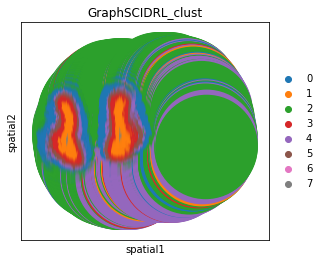

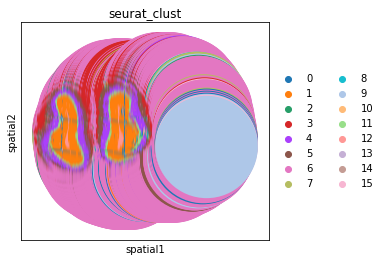

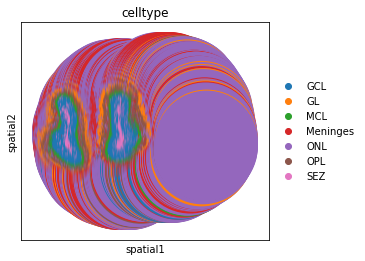

In [16]:
# sc.pl.spatial(adata1,color="GraphSCIDRL_clust", spot_size=100)
# sc.pl.spatial(adata1,color="seurat_clust", spot_size=100)
# sc.pl.spatial(adata1,color="celltype", spot_size=100)

In [ ]:
knn=8
ub=np.unique(adata.obs['batch'])
scs2=[];scs3=[];scs4=[];scs5=[]
for i in np.arange(len(ub)):
    idx=np.where(adata.obs['batch']==ub[i])[0]
    adata1=adata[idx,:]
    if ub[i]=='10X':
        knn=6
#     g1,node_dict1=generate_graph_from_labels(adata1, adata1.obs['GraphSCIDRL_clust'],knn)
#     scs1.append(spatial_coherence_score(g1, node_dict1))
    g2,node_dict2=generate_graph_from_labels(adata1, adata1.obs['seurat_clust'],knn)
    scs2.append(spatial_coherence_score(g2, node_dict2))
    g3,node_dict3=generate_graph_from_labels(adata1, adata1.obs['harmony_clust'],knn)
    scs3.append(spatial_coherence_score(g3, node_dict3))
    g4,node_dict4=generate_graph_from_labels(adata1, adata1.obs['harmony_SEDR_clust'],knn)
    scs4.append(spatial_coherence_score(g4, node_dict4))
    g5,node_dict5=generate_graph_from_labels(adata1, adata1.obs['harmony_STAGATE_clust'],knn)
    scs5.append(spatial_coherence_score(g5, node_dict5))
    
scs=np.array([np.mean(np.abs(scs1)),np.mean(np.abs(scs2)),np.mean(np.abs(scs3)),np.mean(np.abs(scs4)),np.mean(np.abs(scs5))]).reshape(5,1)
method=np.array(['GraphSCIDRL','seurat','harmony','harmony_SEDR','harmony_STAGATE']).reshape(5,1)
data=np.hstack((method,scs))
# pd.DataFrame(data,columns=['method','scs']).to_csv(dirs+'metrics/spatial_coherence_score_'+clust_cate+flags+"_clusters.csv")

In [ ]:
knn=8
ub=np.unique(adata.obs['batch'])
scs1=[]
for i in np.arange(len(ub)):
    idx=np.where(adata.obs['batch']==ub[i])[0]
    adata1=adata[idx,:]
    if ub[i]=='10X':
        knn=6
    g1,node_dict1=generate_graph_from_labels(adata1, adata1.obs['GraphSCIDRL_clust'],knn)
    scs1.append(spatial_coherence_score(g1, node_dict1))

In [30]:
a=pd.read_csv(dirs+'metrics/spatial_coherence_score_'+clust_cate+flags+"_clusters.csv",header=0,index_col=0)
# a.iloc[0,1]=np.mean(np.abs(scs1))
# a.iloc[1,1]=np.mean(np.abs(scs2))
# a.iloc[2,1]=np.mean(np.abs(scs3))
# a.iloc[3,1]=np.mean(np.abs(scs4))
# a.iloc[4,1]=np.mean(np.abs(scs5))
# a.to_csv(dirs+'metrics/spatial_coherence_score_'+clust_cate+flags+"_clusters_1.csv")
a

,method,scs
0,GraphSCIDRL,445.120195
1,seurat,249.424596
2,harmony,211.164821
3,harmony_SEDR,338.662532
4,harmony_STAGATE,440.640020


In [25]:
np.mean(np.abs(scs1))
# scs1

436.71777078342825

In [22]:
i=1
ub=np.unique(adata.obs['batch'])
idx=np.where(adata.obs['batch']==ub[i])[0]
adata1=adata[idx,:]
g1,node_dict1=generate_graph_from_labels(adata1, adata1.obs['GraphSCIDRL_clust'])
a=spatial_coherence_score(g1, node_dict1)

In [23]:
scs1=[scs1,a]

In [24]:
scs1

[-361.5121354800612, -331.1478496079252]

In [ ]:
adata.obs['celltype'][adata.obs['celltype']=='SEZ']='GCL'
adata.obs['celltype'][adata.obs['celltype']=='Meninges']='ONL'
adata.obs['celltype'][adata.obs['celltype']=='OPL']='EPL'

In [ ]:
clust_cate='_louvain'
coord1=pd.read_csv(dirs+"gtt_output/coordinate_file/gtt_new_coordinate"+flags+clust_cate+".csv",header=0,index_col=0)
coord2=pd.read_csv(dirs+"methods/paste_new_coord"+flags+".csv",header=0,index_col=0)
coord1=coord1.loc[adata.obs_names, ['x', 'y']]
adata.obsm["spatial"]=coord1.to_numpy()
knn=6
g1,node_dict1=generate_graph_from_labels(adata, adata.obs['celltype'],knn)
scs1=spatial_coherence_score(g1, node_dict1)

coord2=coord2.loc[adata.obs_names, ['x', 'y']]
adata.obsm["spatial"]=coord2.to_numpy()
knn=6
g2,node_dict2=generate_graph_from_labels(adata, adata.obs['celltype'],knn)
scs2=spatial_coherence_score(g2, node_dict2)
scs=np.array([np.abs(scs1),np.abs(scs2)]).reshape(2,1)
method=np.array(['GraphSCIDRL','PASTE']).reshape(2,1)
data=np.hstack((method,scs))
pd.DataFrame(data,columns=['method','scs']).to_csv(dirs+'metrics/spatial_coherence_score'+clust_cate+flags+"_celltype.csv")

In [ ]:
dirs="/data02/tguo/space_batch_effect/human_DLPFC_10x/"
sample_name=[151507,151508,151509,151510,151669,151670,151671,151672,151673,151674,151675,151676]
IDX=np.arange(len(sample_name))
flags1=str(sample_name[IDX[0]])
for i in np.arange(1,len(IDX)):
    flags1=flags1+'-'+str(sample_name[IDX[i]])
    
i=IDX[0]
feat=pd.read_csv(dirs+"gtt_input_scanpy/"+flags1+'_'+str(sample_name[i])+"_features.txt",header=0,index_col=0,sep=',')
meta=pd.read_csv(dirs+"gtt_input_scanpy/"+flags1+'_'+str(sample_name[i])+"_label.txt",header=0,index_col=0,sep=',')
coord=pd.read_csv(dirs+"gtt_input_scanpy/"+flags1+'_'+str(sample_name[i])+"_positions.txt",header=0,index_col=0,sep=',')
flags='_'+str(sample_name[i])
for sample in np.array(sample_name)[IDX[1:len(IDX)]]:
    feat=pd.concat((feat,pd.read_csv(dirs+"gtt_input_scanpy/"+flags1+'_'+str(sample)+"_features.txt",header=0,index_col=0,sep=',')))
    meta=pd.concat((meta,pd.read_csv(dirs+"gtt_input_scanpy/"+flags1+'_'+str(sample)+"_label.txt",header=0,index_col=0,sep=',')))
    coord=pd.concat((coord,pd.read_csv(dirs+"gtt_input_scanpy/"+flags1+'_'+str(sample)+"_positions.txt",header=0,index_col=0,sep=',')))
    flags=flags+'_'+str(sample)
adata = sc.AnnData(feat)
adata.var_names_make_unique()
coord = coord.loc[adata.obs_names, ['x', 'y']]
adata.obsm["spatial"] = coord.to_numpy()
adata.X=sp.sparse.csr_matrix(adata.X)
adata.obs= meta.loc[adata.obs_names, :]   
adata.obs['batch']=np.array(adata.obs['batch'],dtype=str)

In [ ]:
clust_cate='_mclust'
coord1=pd.read_csv(dirs+"gtt_output/coordinate_file/gtt_new_coordinate"+flags+clust_cate+".csv",header=0,index_co=0)
coord2=pd.read_csv(dirs+"methods/paste_new_coord"+flags+".csv",header=0,index_co=0)
coord1=coord1.loc[adata.obs_names, ['x', 'y']]
adata.obsm["spatial"]=coord1.to_numpy()
knn=6
g1,node_dict1=generate_graph_from_labels(adata, adata.obs['celltype'])
scs1=spatial_coherence_score(g1, node_dict1)

coord2=coord2.loc[adata.obs_names, ['x', 'y']]
adata.obsm["spatial"]=coord2.to_numpy()
knn=6
g2,node_dict2=generate_graph_from_labels(adata, adata.obs['celltype'])
scs2=spatial_coherence_score(g2, node_dict2)

In [ ]:
scs=np.array([np.abs(scs1),np.abs(scs2)]).reshape(-1,1)
method=np.array(['GraphSCIDRL','PASTE']).reshape(-1,1)
data=np.hstack((method,scs))
pd.DataFrame(data,columns=['method','scs']).to_csv(dirs+'metrics/spatial_coherence_score_'+clust_cate+flags+"_celltype.csv")